In [1]:
import zipfile
zip_file = zipfile.ZipFile('/content/train_data_new.zip')
zip_file.extractall('/content/')

In [ ]:
import torch
import numpy as np
import random

# 랜덤 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(33)

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
set_seed(33)
train_transform = A.Compose([
    A.Resize(224, 224),
    A.OneOf([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5)
    ], p=0.5),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        A.MotionBlur(blur_limit=7, p=0.5),
        A.MedianBlur(blur_limit=7, p=0.5)
    ], p=0.5),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

### dataset, dataloader 구축

In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2

class BalancedDataset:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.breeds = os.listdir(root_dir)
        self.all_images = []  

    def prepare_all_data(self):
        self.all_images = []

        for breed in self.breeds:
            happy_dir = os.path.join(self.root_dir, breed, 'happy')
            not_happy_dir = os.path.join(self.root_dir, breed, 'not_happy')

            happy_images = [os.path.join(happy_dir, img) for img in os.listdir(happy_dir)]
            not_happy_images = [os.path.join(not_happy_dir, img) for img in os.listdir(not_happy_dir)]

            self.all_images.extend([(img, 0) for img in happy_images])
            self.all_images.extend([(img, 1) for img in not_happy_images])

        # 이미지 경로와 레이블 분리
        self.img_paths, self.labels = zip(*self.all_images) 

class CustomDataset(Dataset):
    def __init__(self, img_paths, labels=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long) 
            return image, label
        else:
            return image

### dataset, dataloader 구축

In [6]:
train_dir = '/content/train_data_new'

balanced_dataset = BalancedDataset(train_dir)
balanced_dataset.prepare_all_data()

img_paths = balanced_dataset.img_paths
labels = balanced_dataset.labels
train_img_paths, val_img_paths, train_labels, val_labels = train_test_split(
    img_paths, labels, test_size=0.2, random_state=33, stratify=labels
)
print(len(img_paths),len(labels))

train_dataset = CustomDataset(train_img_paths, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_img_paths, val_labels, transform=test_transform)

generator = torch.Generator().manual_seed(33)

train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True, generator=generator
)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

from collections import Counter

train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)

print("Train Labels Distribution:")
print(train_label_counts)

print("\nValidation Labels Distribution:")
print(val_label_counts)

11028 11028
Train Labels Distribution:
Counter({1: 4934, 0: 3888})

Validation Labels Distribution:
Counter({1: 1234, 0: 972})


### train(), validate() 정의

In [ ]:
from tqdm import tqdm

def train(model, criterion, optimizer, train_loader,scheduler=None):
    model.train()
    running_loss = 0.0
    corrects = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if scheduler!=None:
          scheduler.step()

        preds = torch.sigmoid(outputs) > 0.5  
        corrects += torch.sum(preds == labels.byte())

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

def validate(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.float().to(device)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5  
            val_corrects += torch.sum(preds == labels.byte())

    epoch_loss = val_loss / len(val_loader)
    epoch_acc = val_corrects.double() / len(val_loader.dataset)
    return epoch_loss, epoch_acc


In [ ]:
def save_checkpoint(epoch, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'train_losses': train_losses, 
        'val_losses': val_losses,      
        'train_accuracies': train_accuracies,  
        'val_accuracies': val_accuracies       
    }
    torch.save(checkpoint, save_path)

### densenet- AdamW,ReduceLROnPlateau

100%|██████████| 138/138 [00:11<00:00, 12.40it/s]


Epoch 1/50, Train Loss: 0.3575, Train Accuracy: 0.8509, Validation Loss: 0.2234, Validation Accuracy: 0.9157


100%|██████████| 138/138 [00:11<00:00, 11.72it/s]


Epoch 2/50, Train Loss: 0.2865, Train Accuracy: 0.8869, Validation Loss: 0.2288, Validation Accuracy: 0.9125


100%|██████████| 138/138 [00:11<00:00, 12.32it/s]


Epoch 3/50, Train Loss: 0.2618, Train Accuracy: 0.8966, Validation Loss: 0.2288, Validation Accuracy: 0.9198


100%|██████████| 138/138 [00:11<00:00, 12.15it/s]


Epoch 4/50, Train Loss: 0.2495, Train Accuracy: 0.9006, Validation Loss: 0.2016, Validation Accuracy: 0.9288


100%|██████████| 138/138 [00:11<00:00, 12.23it/s]


Epoch 5/50, Train Loss: 0.2390, Train Accuracy: 0.9075, Validation Loss: 0.1888, Validation Accuracy: 0.9329


100%|██████████| 138/138 [00:11<00:00, 12.53it/s]


Epoch 6/50, Train Loss: 0.2407, Train Accuracy: 0.9055, Validation Loss: 0.1939, Validation Accuracy: 0.9329


100%|██████████| 138/138 [00:11<00:00, 12.22it/s]


Epoch 7/50, Train Loss: 0.2213, Train Accuracy: 0.9161, Validation Loss: 0.1841, Validation Accuracy: 0.9302


100%|██████████| 138/138 [00:11<00:00, 12.37it/s]


Epoch 8/50, Train Loss: 0.2042, Train Accuracy: 0.9196, Validation Loss: 0.1827, Validation Accuracy: 0.9325


100%|██████████| 138/138 [00:11<00:00, 12.23it/s]


Epoch 9/50, Train Loss: 0.2000, Train Accuracy: 0.9233, Validation Loss: 0.1832, Validation Accuracy: 0.9306


100%|██████████| 138/138 [00:11<00:00, 12.17it/s]


Epoch 10/50, Train Loss: 0.1771, Train Accuracy: 0.9316, Validation Loss: 0.1996, Validation Accuracy: 0.9234


100%|██████████| 138/138 [00:11<00:00, 12.41it/s]


Epoch 11/50, Train Loss: 0.1827, Train Accuracy: 0.9315, Validation Loss: 0.2332, Validation Accuracy: 0.9166


100%|██████████| 138/138 [00:11<00:00, 12.01it/s]


Epoch 12/50, Train Loss: 0.1508, Train Accuracy: 0.9436, Validation Loss: 0.1798, Validation Accuracy: 0.9374


100%|██████████| 138/138 [00:11<00:00, 12.07it/s]


Epoch 13/50, Train Loss: 0.1374, Train Accuracy: 0.9492, Validation Loss: 0.1837, Validation Accuracy: 0.9343


100%|██████████| 138/138 [00:11<00:00, 12.22it/s]


Epoch 14/50, Train Loss: 0.1292, Train Accuracy: 0.9517, Validation Loss: 0.1812, Validation Accuracy: 0.9402


100%|██████████| 138/138 [00:11<00:00, 12.14it/s]


Epoch 15/50, Train Loss: 0.1192, Train Accuracy: 0.9555, Validation Loss: 0.1918, Validation Accuracy: 0.9370


100%|██████████| 138/138 [00:11<00:00, 12.52it/s]


Epoch 16/50, Train Loss: 0.1116, Train Accuracy: 0.9578, Validation Loss: 0.1876, Validation Accuracy: 0.9361


100%|██████████| 138/138 [00:11<00:00, 11.55it/s]


Epoch 17/50, Train Loss: 0.1086, Train Accuracy: 0.9617, Validation Loss: 0.2023, Validation Accuracy: 0.9329
Early stopping triggered.


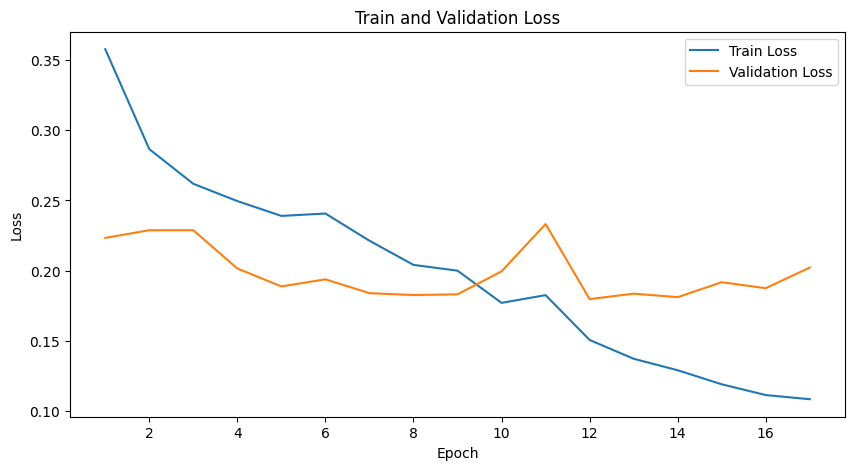

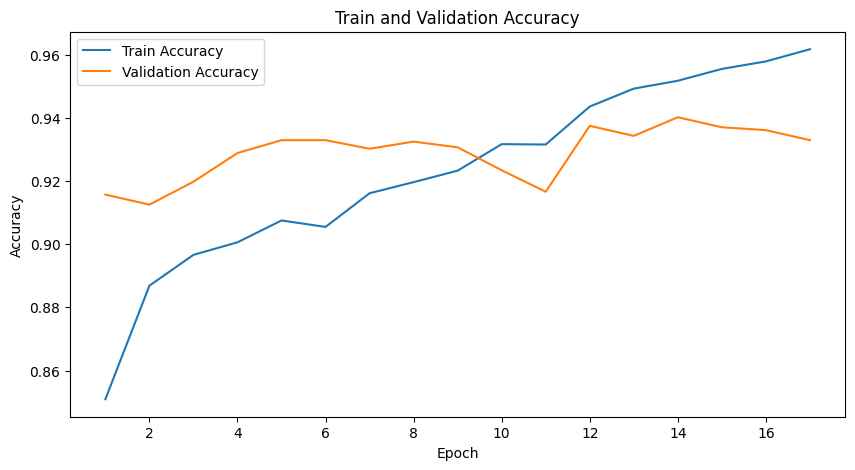

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models

set_seed(33)
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.features.denseblock4.parameters():
    param.requires_grad = True

model.classifier = nn.Linear(model.classifier.in_features, 1)

for param in model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-4  
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
early_stop_patience = 5
best_val_loss = float('inf') 
early_stop_counter = 0  

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  
        save_path = f"/content/de_ada_re_epoch_{epoch+1}.pth"
        save_checkpoint(epoch+1, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1 

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# train, valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# train, valid accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
save_path = f"/content/de_ada_re_b.pth"
save_checkpoint(17, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)

### densenet - sgd, CosineAnnealingLR

100%|██████████| 138/138 [00:10<00:00, 12.81it/s]


Epoch 1/50, Train Loss: 0.4826, Train Accuracy: 0.7927, Validation Loss: 0.2747, Validation Accuracy: 0.9030


100%|██████████| 138/138 [00:11<00:00, 12.44it/s]


Epoch 2/50, Train Loss: 0.3760, Train Accuracy: 0.8558, Validation Loss: 0.2381, Validation Accuracy: 0.9102


100%|██████████| 138/138 [00:11<00:00, 12.15it/s]


Epoch 3/50, Train Loss: 0.3237, Train Accuracy: 0.8781, Validation Loss: 0.3273, Validation Accuracy: 0.8853


100%|██████████| 138/138 [00:11<00:00, 12.28it/s]


Epoch 4/50, Train Loss: 0.2956, Train Accuracy: 0.8844, Validation Loss: 0.2981, Validation Accuracy: 0.8717


100%|██████████| 138/138 [00:11<00:00, 12.29it/s]


Epoch 5/50, Train Loss: 0.2795, Train Accuracy: 0.8913, Validation Loss: 0.2491, Validation Accuracy: 0.9202


100%|██████████| 138/138 [00:11<00:00, 12.31it/s]


Epoch 6/50, Train Loss: 0.2728, Train Accuracy: 0.8978, Validation Loss: 0.3152, Validation Accuracy: 0.8794


100%|██████████| 138/138 [00:11<00:00, 12.31it/s]


Epoch 7/50, Train Loss: 0.2738, Train Accuracy: 0.8979, Validation Loss: 0.2191, Validation Accuracy: 0.9148


100%|██████████| 138/138 [00:11<00:00, 12.39it/s]


Epoch 8/50, Train Loss: 0.2307, Train Accuracy: 0.9102, Validation Loss: 0.1861, Validation Accuracy: 0.9352


100%|██████████| 138/138 [00:11<00:00, 12.11it/s]


Epoch 9/50, Train Loss: 0.2449, Train Accuracy: 0.9060, Validation Loss: 0.2321, Validation Accuracy: 0.9080


100%|██████████| 138/138 [00:11<00:00, 12.34it/s]


Epoch 10/50, Train Loss: 0.2230, Train Accuracy: 0.9167, Validation Loss: 0.1824, Validation Accuracy: 0.9338


100%|██████████| 138/138 [00:11<00:00, 12.26it/s]


Epoch 11/50, Train Loss: 0.1979, Train Accuracy: 0.9236, Validation Loss: 0.2081, Validation Accuracy: 0.9288


100%|██████████| 138/138 [00:11<00:00, 12.24it/s]


Epoch 12/50, Train Loss: 0.2094, Train Accuracy: 0.9214, Validation Loss: 0.2342, Validation Accuracy: 0.9170


100%|██████████| 138/138 [00:11<00:00, 12.33it/s]


Epoch 13/50, Train Loss: 0.2102, Train Accuracy: 0.9191, Validation Loss: 0.2295, Validation Accuracy: 0.9238


100%|██████████| 138/138 [00:11<00:00, 12.35it/s]


Epoch 14/50, Train Loss: 0.1913, Train Accuracy: 0.9254, Validation Loss: 0.2308, Validation Accuracy: 0.9270


100%|██████████| 138/138 [00:11<00:00, 12.38it/s]


Epoch 15/50, Train Loss: 0.1956, Train Accuracy: 0.9238, Validation Loss: 0.1903, Validation Accuracy: 0.9311
Early stopping triggered.


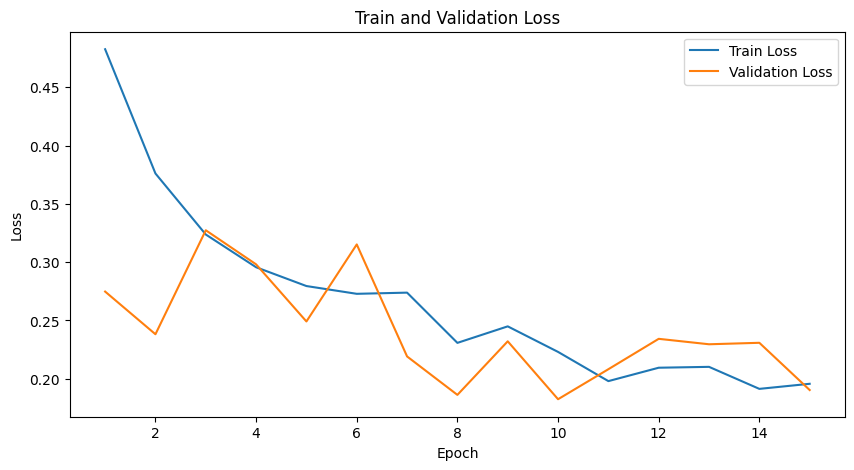

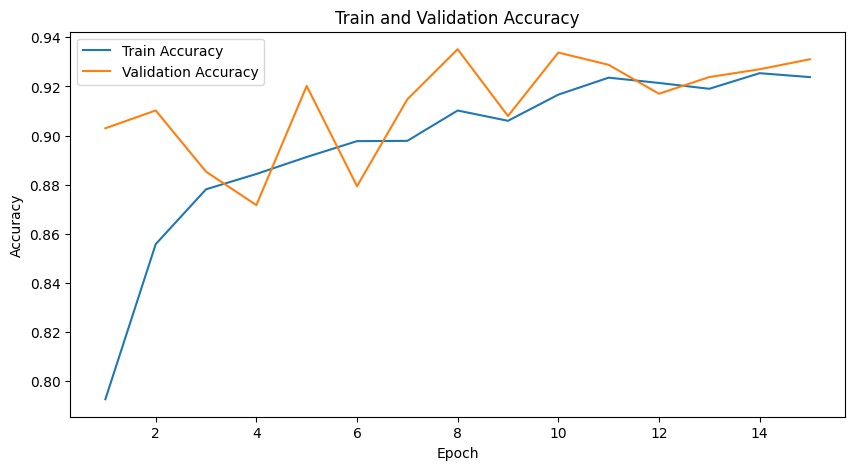

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

set_seed(33)
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.features.denseblock4.parameters():
    param.requires_grad = True

num_classes = 1
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

for param in model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4
)
scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-5)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
early_stop_patience = 5 
best_val_loss = float('inf') 
early_stop_counter = 0  

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader,scheduler)
    val_loss, val_acc = validate(model, criterion, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  
        save_path = f"/content/de_sgd_cos_b_epoch_{epoch+1}.pth"
        save_checkpoint(epoch+1, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1  

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# train, valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# train, valid accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()


In [20]:
save_path = f"/content/de_sgd_cos_b.pth"
save_checkpoint(15, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)

### densenset - sgd

100%|██████████| 138/138 [00:11<00:00, 12.29it/s]


Epoch 1/50, Train Loss: 0.6305, Train Accuracy: 0.6528, Validation Loss: 0.5782, Validation Accuracy: 0.7294


100%|██████████| 138/138 [00:11<00:00, 12.34it/s]


Epoch 2/50, Train Loss: 0.5568, Train Accuracy: 0.7328, Validation Loss: 0.5038, Validation Accuracy: 0.7833


100%|██████████| 138/138 [00:10<00:00, 12.74it/s]


Epoch 3/50, Train Loss: 0.5032, Train Accuracy: 0.7741, Validation Loss: 0.4357, Validation Accuracy: 0.8200


100%|██████████| 138/138 [00:11<00:00, 12.35it/s]


Epoch 4/50, Train Loss: 0.4627, Train Accuracy: 0.7955, Validation Loss: 0.3890, Validation Accuracy: 0.8477


100%|██████████| 138/138 [00:11<00:00, 12.42it/s]


Epoch 5/50, Train Loss: 0.4243, Train Accuracy: 0.8174, Validation Loss: 0.3496, Validation Accuracy: 0.8645


100%|██████████| 138/138 [00:11<00:00, 12.26it/s]


Epoch 6/50, Train Loss: 0.3992, Train Accuracy: 0.8304, Validation Loss: 0.3064, Validation Accuracy: 0.8867


100%|██████████| 138/138 [00:11<00:00, 12.44it/s]


Epoch 7/50, Train Loss: 0.3705, Train Accuracy: 0.8414, Validation Loss: 0.2877, Validation Accuracy: 0.8885


100%|██████████| 138/138 [00:11<00:00, 12.38it/s]


Epoch 8/50, Train Loss: 0.3572, Train Accuracy: 0.8497, Validation Loss: 0.2754, Validation Accuracy: 0.8930


100%|██████████| 138/138 [00:11<00:00, 12.43it/s]


Epoch 9/50, Train Loss: 0.3518, Train Accuracy: 0.8548, Validation Loss: 0.2613, Validation Accuracy: 0.9003


100%|██████████| 138/138 [00:11<00:00, 12.42it/s]


Epoch 10/50, Train Loss: 0.3325, Train Accuracy: 0.8603, Validation Loss: 0.2563, Validation Accuracy: 0.9021


100%|██████████| 138/138 [00:11<00:00, 12.38it/s]


Epoch 11/50, Train Loss: 0.3394, Train Accuracy: 0.8566, Validation Loss: 0.2485, Validation Accuracy: 0.9039


100%|██████████| 138/138 [00:10<00:00, 12.61it/s]


Epoch 12/50, Train Loss: 0.3261, Train Accuracy: 0.8661, Validation Loss: 0.2412, Validation Accuracy: 0.9107


100%|██████████| 138/138 [00:11<00:00, 12.40it/s]


Epoch 13/50, Train Loss: 0.3150, Train Accuracy: 0.8729, Validation Loss: 0.2446, Validation Accuracy: 0.9048


100%|██████████| 138/138 [00:10<00:00, 12.56it/s]


Epoch 14/50, Train Loss: 0.3125, Train Accuracy: 0.8720, Validation Loss: 0.2319, Validation Accuracy: 0.9161


100%|██████████| 138/138 [00:11<00:00, 12.30it/s]


Epoch 15/50, Train Loss: 0.3160, Train Accuracy: 0.8684, Validation Loss: 0.2290, Validation Accuracy: 0.9161


100%|██████████| 138/138 [00:11<00:00, 12.32it/s]


Epoch 16/50, Train Loss: 0.3002, Train Accuracy: 0.8749, Validation Loss: 0.2264, Validation Accuracy: 0.9125


100%|██████████| 138/138 [00:11<00:00, 12.27it/s]


Epoch 17/50, Train Loss: 0.3040, Train Accuracy: 0.8723, Validation Loss: 0.2244, Validation Accuracy: 0.9220


100%|██████████| 138/138 [00:11<00:00, 12.40it/s]


Epoch 18/50, Train Loss: 0.2929, Train Accuracy: 0.8771, Validation Loss: 0.2234, Validation Accuracy: 0.9098


100%|██████████| 138/138 [00:11<00:00, 12.30it/s]


Epoch 19/50, Train Loss: 0.2918, Train Accuracy: 0.8781, Validation Loss: 0.2168, Validation Accuracy: 0.9211


100%|██████████| 138/138 [00:11<00:00, 12.40it/s]


Epoch 20/50, Train Loss: 0.2865, Train Accuracy: 0.8828, Validation Loss: 0.2127, Validation Accuracy: 0.9175


100%|██████████| 138/138 [00:11<00:00, 12.44it/s]


Epoch 21/50, Train Loss: 0.2857, Train Accuracy: 0.8835, Validation Loss: 0.2132, Validation Accuracy: 0.9166


100%|██████████| 138/138 [00:11<00:00, 12.29it/s]


Epoch 22/50, Train Loss: 0.2767, Train Accuracy: 0.8857, Validation Loss: 0.2057, Validation Accuracy: 0.9266


100%|██████████| 138/138 [00:11<00:00, 12.42it/s]


Epoch 23/50, Train Loss: 0.2749, Train Accuracy: 0.8879, Validation Loss: 0.2091, Validation Accuracy: 0.9207


100%|██████████| 138/138 [00:11<00:00, 12.33it/s]


Epoch 24/50, Train Loss: 0.2733, Train Accuracy: 0.8910, Validation Loss: 0.2054, Validation Accuracy: 0.9257


100%|██████████| 138/138 [00:11<00:00, 12.43it/s]


Epoch 25/50, Train Loss: 0.2628, Train Accuracy: 0.8922, Validation Loss: 0.2021, Validation Accuracy: 0.9216


100%|██████████| 138/138 [00:11<00:00, 12.35it/s]


Epoch 26/50, Train Loss: 0.2575, Train Accuracy: 0.8966, Validation Loss: 0.1989, Validation Accuracy: 0.9266


100%|██████████| 138/138 [00:11<00:00, 12.38it/s]


Epoch 27/50, Train Loss: 0.2632, Train Accuracy: 0.8961, Validation Loss: 0.2102, Validation Accuracy: 0.9134


100%|██████████| 138/138 [00:11<00:00, 12.26it/s]


Epoch 28/50, Train Loss: 0.2651, Train Accuracy: 0.8971, Validation Loss: 0.1986, Validation Accuracy: 0.9270


100%|██████████| 138/138 [00:11<00:00, 12.31it/s]


Epoch 29/50, Train Loss: 0.2517, Train Accuracy: 0.8984, Validation Loss: 0.1992, Validation Accuracy: 0.9234


100%|██████████| 138/138 [00:11<00:00, 12.44it/s]


Epoch 30/50, Train Loss: 0.2547, Train Accuracy: 0.8980, Validation Loss: 0.1983, Validation Accuracy: 0.9234


100%|██████████| 138/138 [00:11<00:00, 12.39it/s]


Epoch 31/50, Train Loss: 0.2542, Train Accuracy: 0.8983, Validation Loss: 0.1958, Validation Accuracy: 0.9279


100%|██████████| 138/138 [00:11<00:00, 12.24it/s]


Epoch 32/50, Train Loss: 0.2461, Train Accuracy: 0.9023, Validation Loss: 0.1921, Validation Accuracy: 0.9252


100%|██████████| 138/138 [00:11<00:00, 12.17it/s]


Epoch 33/50, Train Loss: 0.2415, Train Accuracy: 0.8993, Validation Loss: 0.1917, Validation Accuracy: 0.9248


100%|██████████| 138/138 [00:11<00:00, 12.01it/s]


Epoch 34/50, Train Loss: 0.2438, Train Accuracy: 0.9007, Validation Loss: 0.1935, Validation Accuracy: 0.9284


100%|██████████| 138/138 [00:11<00:00, 12.44it/s]


Epoch 35/50, Train Loss: 0.2467, Train Accuracy: 0.9017, Validation Loss: 0.1952, Validation Accuracy: 0.9229


100%|██████████| 138/138 [00:10<00:00, 12.66it/s]


Epoch 36/50, Train Loss: 0.2371, Train Accuracy: 0.9018, Validation Loss: 0.1987, Validation Accuracy: 0.9184


100%|██████████| 138/138 [00:11<00:00, 12.34it/s]


Epoch 37/50, Train Loss: 0.2407, Train Accuracy: 0.9052, Validation Loss: 0.1872, Validation Accuracy: 0.9266


100%|██████████| 138/138 [00:11<00:00, 11.78it/s]


Epoch 38/50, Train Loss: 0.2375, Train Accuracy: 0.9051, Validation Loss: 0.1884, Validation Accuracy: 0.9279


100%|██████████| 138/138 [00:11<00:00, 12.48it/s]


Epoch 39/50, Train Loss: 0.2248, Train Accuracy: 0.9058, Validation Loss: 0.1896, Validation Accuracy: 0.9288


100%|██████████| 138/138 [00:11<00:00, 12.18it/s]


Epoch 40/50, Train Loss: 0.2267, Train Accuracy: 0.9089, Validation Loss: 0.1881, Validation Accuracy: 0.9284


100%|██████████| 138/138 [00:10<00:00, 12.58it/s]


Epoch 41/50, Train Loss: 0.2260, Train Accuracy: 0.9107, Validation Loss: 0.1833, Validation Accuracy: 0.9279


100%|██████████| 138/138 [00:11<00:00, 12.05it/s]


Epoch 42/50, Train Loss: 0.2256, Train Accuracy: 0.9081, Validation Loss: 0.1881, Validation Accuracy: 0.9243


100%|██████████| 138/138 [00:11<00:00, 12.33it/s]


Epoch 43/50, Train Loss: 0.2295, Train Accuracy: 0.9080, Validation Loss: 0.1852, Validation Accuracy: 0.9284


100%|██████████| 138/138 [00:11<00:00, 12.31it/s]


Epoch 44/50, Train Loss: 0.2273, Train Accuracy: 0.9089, Validation Loss: 0.1806, Validation Accuracy: 0.9270


100%|██████████| 138/138 [00:11<00:00, 12.22it/s]


Epoch 45/50, Train Loss: 0.2284, Train Accuracy: 0.9098, Validation Loss: 0.1857, Validation Accuracy: 0.9320


100%|██████████| 138/138 [00:10<00:00, 12.71it/s]


Epoch 46/50, Train Loss: 0.2232, Train Accuracy: 0.9095, Validation Loss: 0.1845, Validation Accuracy: 0.9306


100%|██████████| 138/138 [00:11<00:00, 12.27it/s]


Epoch 47/50, Train Loss: 0.2165, Train Accuracy: 0.9131, Validation Loss: 0.1823, Validation Accuracy: 0.9261


100%|██████████| 138/138 [00:10<00:00, 12.59it/s]


Epoch 48/50, Train Loss: 0.2136, Train Accuracy: 0.9139, Validation Loss: 0.1822, Validation Accuracy: 0.9248


100%|██████████| 138/138 [00:11<00:00, 12.30it/s]


Epoch 49/50, Train Loss: 0.2036, Train Accuracy: 0.9175, Validation Loss: 0.1822, Validation Accuracy: 0.9325
Early stopping triggered.


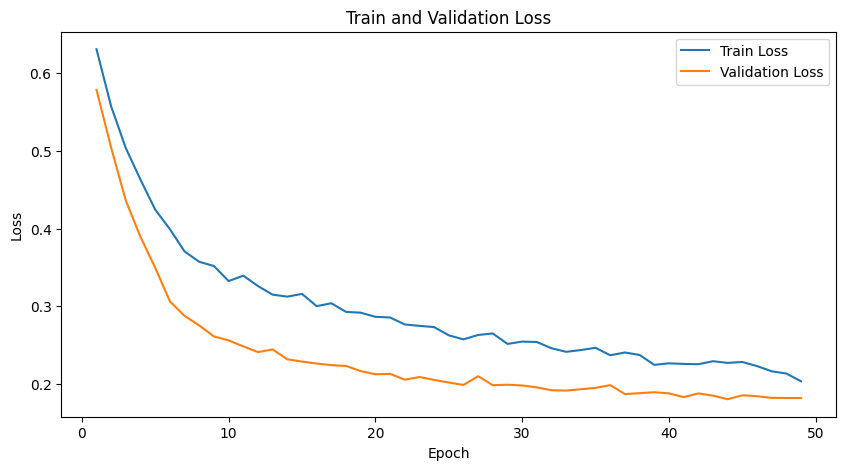

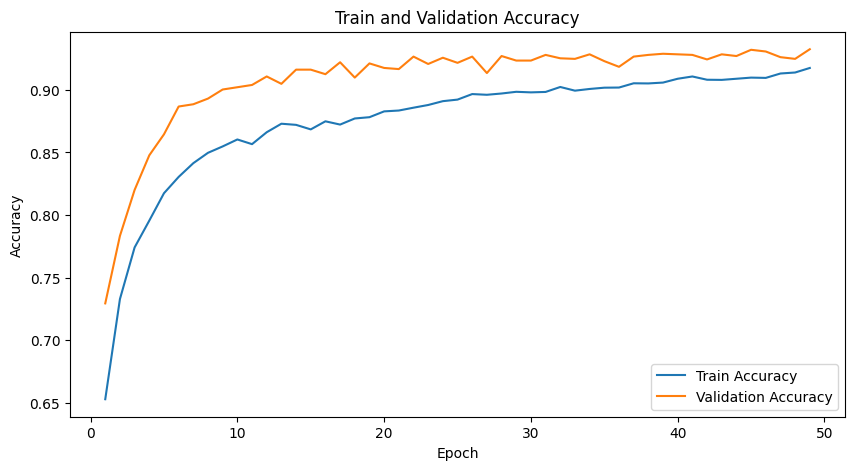

In [ ]:

set_seed(33)
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.features.denseblock4.parameters():
    param.requires_grad = True

num_classes = 1
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

for param in model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    momentum=0.9,
    weight_decay=1e-4
)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
early_stop_patience = 5 
best_val_loss = float('inf')
early_stop_counter = 0 

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  
        save_path = f"/content/de_sgd_b_epoch_{epoch+1}.pth"
        save_checkpoint(epoch+1, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1  

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# train, valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# train, valid accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()


In [16]:
save_path = f"/content/de_sgd_b.pth"
save_checkpoint(49, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)

### densenet - AdamW

100%|██████████| 138/138 [00:11<00:00, 12.52it/s]


Epoch 1/50, Train Loss: 0.3579, Train Accuracy: 0.8509, Validation Loss: 0.2114, Validation Accuracy: 0.9211


100%|██████████| 138/138 [00:11<00:00, 12.48it/s]


Epoch 2/50, Train Loss: 0.2882, Train Accuracy: 0.8852, Validation Loss: 0.2066, Validation Accuracy: 0.9211


100%|██████████| 138/138 [00:11<00:00, 12.35it/s]


Epoch 3/50, Train Loss: 0.2595, Train Accuracy: 0.8954, Validation Loss: 0.2104, Validation Accuracy: 0.9202


100%|██████████| 138/138 [00:11<00:00, 12.47it/s]


Epoch 4/50, Train Loss: 0.2500, Train Accuracy: 0.9031, Validation Loss: 0.1920, Validation Accuracy: 0.9325


100%|██████████| 138/138 [00:10<00:00, 12.68it/s]


Epoch 5/50, Train Loss: 0.2375, Train Accuracy: 0.9042, Validation Loss: 0.1901, Validation Accuracy: 0.9320


100%|██████████| 138/138 [00:11<00:00, 12.44it/s]


Epoch 6/50, Train Loss: 0.2268, Train Accuracy: 0.9103, Validation Loss: 0.1864, Validation Accuracy: 0.9261


100%|██████████| 138/138 [00:10<00:00, 12.80it/s]


Epoch 7/50, Train Loss: 0.2113, Train Accuracy: 0.9191, Validation Loss: 0.1782, Validation Accuracy: 0.9334


100%|██████████| 138/138 [00:11<00:00, 12.25it/s]


Epoch 8/50, Train Loss: 0.2053, Train Accuracy: 0.9176, Validation Loss: 0.2109, Validation Accuracy: 0.9252


100%|██████████| 138/138 [00:10<00:00, 12.66it/s]


Epoch 9/50, Train Loss: 0.1846, Train Accuracy: 0.9284, Validation Loss: 0.1926, Validation Accuracy: 0.9343


100%|██████████| 138/138 [00:11<00:00, 12.41it/s]


Epoch 10/50, Train Loss: 0.1859, Train Accuracy: 0.9299, Validation Loss: 0.1869, Validation Accuracy: 0.9406


100%|██████████| 138/138 [00:11<00:00, 12.45it/s]


Epoch 11/50, Train Loss: 0.1812, Train Accuracy: 0.9326, Validation Loss: 0.2004, Validation Accuracy: 0.9329


100%|██████████| 138/138 [00:11<00:00, 12.25it/s]


Epoch 12/50, Train Loss: 0.1692, Train Accuracy: 0.9363, Validation Loss: 0.2103, Validation Accuracy: 0.9275
Early stopping triggered.


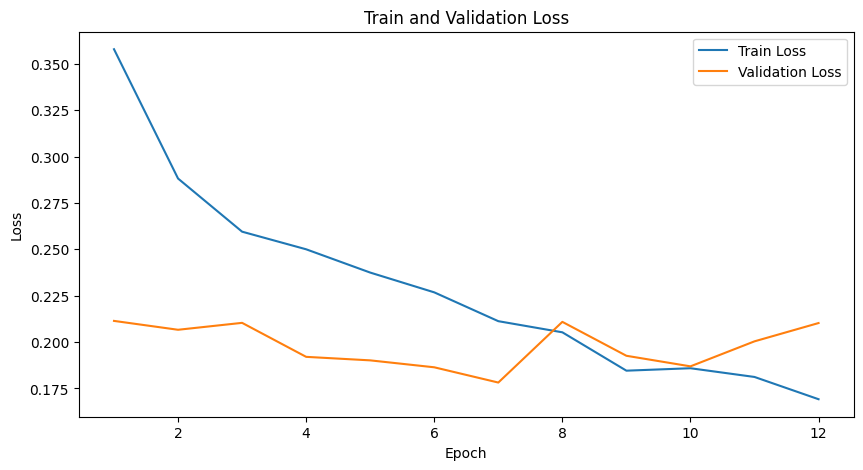

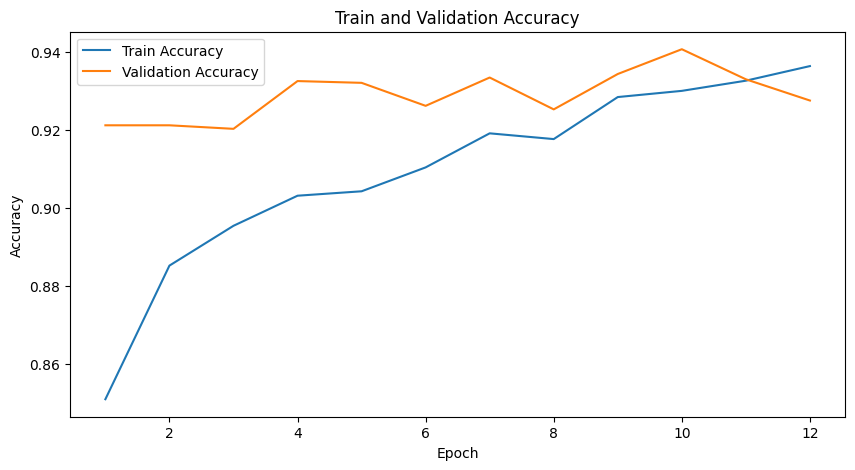

In [ ]:
import torch.nn as nn
import torch.optim as optim

set_seed(33)
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.features.denseblock4.parameters():
    param.requires_grad = True

num_classes = 1
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

for param in model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
early_stop_patience = 5 
best_val_loss = float('inf') 
early_stop_counter = 0  

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0 
        save_path = f"/content/de_ada_b_epoch_{epoch+1}.pth"
        save_checkpoint(epoch+1, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1 

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# train, valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# train, valid accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [18]:
save_path = f"/content/de_ada_b.pth"
save_checkpoint(12, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)